<a href="https://colab.research.google.com/github/sazio/MultiAgentCovid/blob/master/Multiplex_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Data and match Agents with Buildings

In [1]:
import numpy as np 
import pandas as pd # data handling
import glob # folder and path handling
from tqdm.notebook import tqdm # measuring for loops runtime
from scipy import sparse # to export sparse adjacency matrices
import matplotlib.pyplot as plt # plot 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data from GDrive
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [3]:
path = "drive/MyDrive/MAS/Data/Output_GAMA/Data" # path to folder & files
#agents_path = path + "/Agents_Final"
agents_path = path + "/Agents_Batch" # path to agents files , gama export
buildings_path = path + "/Buildings" # path to buildings file, gama export 

agents_files = [] #glob.glob(agents_path + "/*.csv")
# glob order wasn't matching the gama one, so i had to sort files manually
for i in range(0,24):
  agents_files.append(agents_path + "/Agents_" + str(i) + ".csv")

# getting data for the first day 
agents_1_day = [agents_files[i] for i in range(0,24)]
buildings_file = glob.glob(buildings_path + "/*.csv")

### Buildings Dataframe 
It specifies the name of each building with related x, y location on the map

In [ ]:
DF_buildings = pd.read_csv(buildings_file[0], sep = ",", names = ["name", "loc_x", "loc_y", "loc_z"])
DF_buildings = DF_buildings.iloc[1:]
DF_buildings = DF_buildings.reset_index(drop = True)
DF_buildings["name"] = DF_buildings["name"].str[:8] + "(" + DF_buildings["name"].str[8:] + ")"
DF_buildings["loc_x"] = DF_buildings["loc_x"].str[1:].astype(np.float32)
DF_buildings["loc_y"] = DF_buildings["loc_y"].astype(np.float32)
DF_buildings["loc_z"] = DF_buildings["loc_z"].str[:-1].astype(np.float32)

DF_buildings.head()

,name,loc_x,loc_y,loc_z
0,building(0),4258.587891,8622.923828,0.0
1,building(1),4205.688477,8554.613281,0.0
2,building(2),4172.957031,8508.589844,0.0
3,building(3),4653.243164,8230.745117,0.0
4,building(4),4630.689941,8173.111816,0.0


### Agents Dataframe
Here we deal with the first cycle only ("Agents_0.csv") for a feasibility study. 

`ToDo: implement a function from this in order to process days instead of single cycles`


In [ ]:
# Reading csv and setting it as a pandas dataframe
DF_agents = pd.read_csv(agents_files[0], sep = ",", names = ["name", "cycle","loc_x", "loc_y", "loc_z","living_place",
"working_place","worship_place","school","stuff_place_1", "stuff_place_2", "is_susceptible", "is_infected", "is_immune"])

DF_agents = DF_agents.iloc[1:]
DF_agents = DF_agents.reset_index(drop = True)
DF_agents["loc_x"] = DF_agents["loc_x"].str[1:].astype(np.float32) # dtype conversion
DF_agents["loc_y"] = DF_agents["loc_y"].astype(np.float32)
DF_agents["loc_z"] = DF_agents["loc_z"].str[:-1].astype(np.float32)

DF_agents = DF_agents.replace({"is_susceptible":{"True":True, "False":False}})  # dtype conversion
DF_agents = DF_agents.replace({"is_infected":{"True":True, "False":False}})
DF_agents = DF_agents.replace({"is_immune":{"True":True, "False":False}})

#DF_agents = DF_agents[DF_agents.living_place != "nil"]
#DF_agents = DF_agents[DF_agents.working_place != "nil"]
#DF_agents = DF_agents[DF_agents.stuff_place != "nil"]

DF_agents.head()

,name,cycle,loc_x,loc_y,loc_z,living_place,working_place,worship_place,school,stuff_place_1,stuff_place_2,is_susceptible,is_infected,is_immune
0,people0,0,3611.613770,630.453186,0.0,building(6836),building(2599),building(7105),nil,building(1395),building(3381),true,False,False
1,people1,0,5048.931641,3909.448730,0.0,building(4677),building(2293),building(7095),nil,building(4657),building(6398),true,False,False
2,people2,0,5167.712891,4174.493652,0.0,building(2894),building(150),building(7082),nil,building(5103),building(1325),true,False,False
3,people3,0,4092.845215,3301.237305,0.0,building(3986),building(83),building(7099),nil,building(4657),building(1407),true,False,False
4,people4,0,5351.062012,3371.890137,0.0,building(5025),building(5885),building(7096),nil,building(5103),building(2227),true,False,False


In [ ]:
# making sure that agents are praying (sometimes, oh lord!!!)
# DF_agents[DF_agents.worship_place != "nil"]

,name,cycle,loc_x,loc_y,loc_z,living_place,working_place,worship_place,school,stuff_place_1,stuff_place_2,is_susceptible,is_infected,is_immune


### Contact Tracing

Spatial Filter on agents location, we can check whether they are inside a specific building or on their way to some place. 
(This won't be part of the feasibility study)

`ToDo: faster implementation for nearly real-time contact tracing`


In [ ]:
def is_in_which_building(DF_buildings, DF_agents, agent_index, spatial_filter = 70):

  """
  Check if the agent is in some building or in the street (if alive), useful to build a multiplex network 

  """
  #  names = ["name", "cycle","loc_x", "loc_y", "loc_z","living_place", "working_place","worship_place","school","stuff_place_1", "stuff_place_2", "is_susceptible", "is_infected", "is_immune"]
  
  # In case living place is "nil", i.e. non existing, it basically means that our agent is dead (hopefully we won't have this case)
  if DF_agents.values[agent_index,5]  == "nil":
    return "Dead"

  #elif DF_agents.values[agent_index,6] == "nil":  
    #return "Dead"

  #elif DF_agents.values[agent_index,7] == "nil": 
    #return "Dead"

  # In case our agent is alive 
  else:

    agent_coord = DF_agents.values[agent_index,2:4] # where the agent is right now 
    living_coord = DF_buildings[DF_buildings.name == DF_agents.values[agent_index,5]].values[0][1:3] # living place coordinates
    living_ag_dist = np.linalg.norm(living_coord - agent_coord)
    
    # handling working "nil" values
    if DF_agents.values[agent_index,6] == "nil":
      #working_coord = [-1000,-1000] # [-1000,-1000] custom value for who's not working
      working_ag_dist = 1000000
    else:
      working_coord = DF_buildings[DF_buildings.name == DF_agents.values[agent_index,6]].values[0][1:3]
      working_ag_dist = np.linalg.norm(working_coord - agent_coord)

    
    # handling working "nil" values
    if DF_agents.values[agent_index,7] == "nil":
      #worship_coord = [-10000,-10000] # [-1000,-1000] custom value for who's not believing in the lord!!
      worship_ag_dist = 1000000
    else:
      worship_coord = DF_buildings[DF_buildings.name == DF_agents.values[agent_index,7]].values[0][1:3]
      worship_ag_dist = np.linalg.norm(worship_coord - agent_coord)
      
    # handling school "nil" values
    if DF_agents.values[agent_index,8] == "nil": 
      #school_coord = [-10000,-10000] # [-1000,-1000] custom value for who's not going to school
      school_ag_dist = 1000000
    else:
      school_coord = DF_buildings[DF_buildings.name == DF_agents.values[agent_index,8]].values[0][1:3]
      school_ag_dist = np.linalg.norm(school_coord - agent_coord)

    # handling stuff_1 "nil" values
    if DF_agents.values[agent_index,9] == "nil": 
      #stuff_1_coord = [-10000,-10000] # [-1000,-1000] custom value for who's not doing some stuff_1
      stuff_1_ag_dist = 1000000
    else:
      stuff_1_coord = DF_buildings[DF_buildings.name == DF_agents.values[agent_index,9]].values[0][1:3]
      stuff_1_ag_dist = np.linalg.norm(stuff_1_coord - agent_coord)

    # handling stuff_2 "nil" values
    if DF_agents.values[agent_index,10] == "nil": 
      #stuff_2_coord = [-10000,-10000] # [-1000,-1000] custom value for who's not doing some stuff_2
      stuff_2_ag_dist = 1000000
    else:
      stuff_2_coord = DF_buildings[DF_buildings.name == DF_agents.values[agent_index,10]].values[0][1:3]
      stuff_2_ag_dist = np.linalg.norm(stuff_2_coord - agent_coord)    
    

    if min(living_ag_dist, working_ag_dist, worship_ag_dist, school_ag_dist, stuff_1_ag_dist, stuff_2_ag_dist) == living_ag_dist and living_ag_dist < spatial_filter:
      return DF_agents.values[agent_index,5]

    elif  min(living_ag_dist, working_ag_dist, worship_ag_dist, school_ag_dist, stuff_1_ag_dist, stuff_2_ag_dist) == working_ag_dist and working_ag_dist < spatial_filter:
      return DF_agents.values[agent_index,6]

    elif  min(living_ag_dist, working_ag_dist, worship_ag_dist, school_ag_dist, stuff_1_ag_dist, stuff_2_ag_dist) == worship_ag_dist and worship_ag_dist < spatial_filter:
      return DF_agents.values[agent_index,7]
    
    elif  min(living_ag_dist, working_ag_dist, worship_ag_dist, school_ag_dist, stuff_1_ag_dist, stuff_2_ag_dist) == school_ag_dist and school_ag_dist < spatial_filter:
      return DF_agents.values[agent_index,8]
    
    elif  min(living_ag_dist, working_ag_dist, worship_ag_dist, school_ag_dist, stuff_1_ag_dist, stuff_2_ag_dist) == stuff_1_ag_dist and stuff_1_ag_dist < spatial_filter:
      return DF_agents.values[agent_index,9]

    elif  min(living_ag_dist, working_ag_dist, worship_ag_dist, school_ag_dist, stuff_1_ag_dist, stuff_2_ag_dist) == stuff_2_ag_dist and stuff_2_ag_dist < spatial_filter:
      return DF_agents.values[agent_index,10]

    # In case our agent is on the road to some place 
    else: 
      return "None"

In [ ]:
# ToDo, iterrows is not the most efficient, find a faster way (e.g. apply)
for index,row in tqdm(DF_agents.iterrows(), total = DF_agents.shape[0]):
  DF_agents.loc[index,'current_location'] = is_in_which_building(DF_buildings, DF_agents, agent_index = index)

In [ ]:
#DF_agents.to_csv(path + "/DF_Agents/DF_Agents_0.csv", index = False)

In [ ]:
#DF_agents = pd.read_csv(path + "/DF_Agents/DF_Agents_0.csv")

In [ ]:
#DF_agents.head()

,name,cycle,loc_x,loc_y,loc_z,living_place,working_place,worship_place,school,stuff_place_1,stuff_place_2,is_susceptible,is_infected,is_immune,current_location,x_living,y_living,x_working,y_working,x_school,y_school,x_stuff_1,y_stuff_1,x_stuff_2,y_stuff_2
0,people0,0,5451.1826,4087.6777,0.0,building(2975),building(2463),nil,nil,building(3381),building(2228),True,False,False,building(2975),5452.779785,4081.980713,651.389893,889.541016,NaN,NaN,4170.485840,4223.511719,2327.664795,4158.613281
1,people1,0,1828.7894,3167.4236,0.0,building(546),building(2639),nil,nil,building(1325),building(1325),True,False,False,building(546),1830.203369,3164.084229,6016.277344,6839.055176,NaN,NaN,1970.929199,3252.865479,1970.929199,3252.865479
2,people2,0,1469.1023,3089.7480,0.0,building(780),building(3419),nil,nil,building(1401),building(6446),True,False,False,building(780),1476.925293,3091.914795,4891.178711,4681.766113,NaN,NaN,3370.055908,4443.623535,3682.401367,820.076477
3,people3,0,3957.1313,1626.9391,0.0,building(6178),building(3069),nil,nil,building(4918),building(1401),True,False,False,building(6178),3940.652344,1615.547607,4355.027344,5588.401367,NaN,NaN,5012.208496,3519.045654,3370.055908,4443.623535
4,people4,0,3714.4565,2350.6719,0.0,building(5623),building(3132),nil,nil,building(6182),building(6229),True,False,False,building(5623),3718.599121,2352.267090,5702.873047,5683.415527,NaN,NaN,4051.546143,1938.535034,4022.726318,1850.860962


# Multiplex Analysis

Start by downloading a Python library, namely [multinetx](https://https://github.com/nkoub/multinetx)

In [ ]:
#!pip install git+https://github.com/nkoub/multinetx.git

In [ ]:
import multinetx as mx

### Create weighted links for each layer
In this way we can have a direct measure of time spent in some specific location

(Not part of the feasibility study)

In [ ]:
# run in approx 3.5 mins 
for index, row in tqdm(DF_agents.iterrows(), total = DF_agents.shape[0]):
  try: 
    DF_agents.loc[index, "x_living"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].living_place])].loc_x.values[0]
    DF_agents.loc[index, "y_living"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].living_place])].loc_y.values[0]

    DF_agents.loc[index, "x_working"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].working_place])].loc_x.values[0]
    DF_agents.loc[index,  "y_working"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].working_place])].loc_y.values[0]

  except IndexError: #corresponds to "nil" values 
    pass

In [ ]:
for index, row in tqdm(DF_agents.iterrows(), total = DF_agents.shape[0]):
  try: 
    DF_agents.loc[index, "x_worship"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].worship_place])].loc_x.values[0]
    DF_agents.loc[index, "y_worship"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].worship_place])].loc_y.values[0]

  except IndexError:
    pass

In [ ]:
for index, row in tqdm(DF_agents.iterrows(), total = DF_agents.shape[0]):
  try: 
    DF_agents.loc[index, "x_school"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].school])].loc_x.values[0]
    DF_agents.loc[index, "y_school"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].school])].loc_y.values[0]
    
  except IndexError:
    pass

In [ ]:
for index, row in tqdm(DF_agents.iterrows(), total = DF_agents.shape[0]):
  try: 

    DF_agents.loc[index, "x_stuff_1"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].stuff_place_1])].loc_x.values[0]
    DF_agents.loc[index, "y_stuff_1"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].stuff_place_1])].loc_y.values[0]

  except IndexError:
    pass

In [ ]:
for index, row in tqdm(DF_agents.iterrows(), total = DF_agents.shape[0]):
  try: 

    DF_agents.loc[index, "x_stuff_2"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].stuff_place_2])].loc_x.values[0]
    DF_agents.loc[index, "y_stuff_2"] = DF_buildings[DF_buildings.name.isin([DF_agents.iloc[index].stuff_place_2])].loc_y.values[0]

  except IndexError:
    pass

In [ ]:
#DF_agents = DF_agents.drop(columns = ["Unnamed: 0"])
#DF_agents.to_csv(path + "/DF_Agents/DF_Agents_0.csv", index = False)

In [ ]:
#DF_agents = pd.read_csv(path + "/DF_Agents/DF_Agents_0.csv")
#DF_agents.head()

,name,cycle,loc_x,loc_y,loc_z,living_place,working_place,worship_place,school,stuff_place_1,stuff_place_2,is_susceptible,is_infected,is_immune,current_location,x_living,y_living,x_working,y_working,x_school,y_school,x_stuff_1,y_stuff_1,x_stuff_2,y_stuff_2
0,people0,0,5451.1826,4087.6777,0.0,building(2975),building(2463),nil,nil,building(3381),building(2228),True,False,False,building(2975),5452.779785,4081.980713,651.389893,889.541016,NaN,NaN,4170.485840,4223.511719,2327.664795,4158.613281
1,people1,0,1828.7894,3167.4236,0.0,building(546),building(2639),nil,nil,building(1325),building(1325),True,False,False,building(546),1830.203369,3164.084229,6016.277344,6839.055176,NaN,NaN,1970.929199,3252.865479,1970.929199,3252.865479
2,people2,0,1469.1023,3089.7480,0.0,building(780),building(3419),nil,nil,building(1401),building(6446),True,False,False,building(780),1476.925293,3091.914795,4891.178711,4681.766113,NaN,NaN,3370.055908,4443.623535,3682.401367,820.076477
3,people3,0,3957.1313,1626.9391,0.0,building(6178),building(3069),nil,nil,building(4918),building(1401),True,False,False,building(6178),3940.652344,1615.547607,4355.027344,5588.401367,NaN,NaN,5012.208496,3519.045654,3370.055908,4443.623535
4,people4,0,3714.4565,2350.6719,0.0,building(5623),building(3132),nil,nil,building(6182),building(6229),True,False,False,building(5623),3718.599121,2352.267090,5702.873047,5683.415527,NaN,NaN,4051.546143,1938.535034,4022.726318,1850.860962


## Adjacency matrix for each layer 

In [ ]:
# Function for making an adjecency matrix 
def make_adj_matrix(column):
  num_elements = column.shape[0]
  adj_matrix = np.eye(num_elements, dtype = np.int8) # casting to int to avoid RAM crash on colab

  for i in tqdm(range(0, num_elements)):
    for j in range(0, num_elements):
      
      if (column.values[i] == "nil") or (column.values[j] == "nil"):
        adj_matrix[i][j] = 0
      elif column.values[i] == column.values[j]:
        adj_matrix[i][j] = 1
      else:
        adj_matrix[i][j] = 0

  return adj_matrix

In [ ]:
# Vectorizing adjacency matrix in order to run efficiently for 30k elements 
#vec_adj_matrix = np.vectorize(make_adj_matrix, excluded = ["column"])

In [ ]:
#Takes approx 43 mins instead of 89 hrs
living_adj = make_adj_matrix(column = DF_agents.living_place)

In [ ]:
sparse_living_adj = sparse.csr_matrix(living_adj)
sparse.save_npz(path + '/sparse_living_adj.npz', sparse_living_adj)

In [ ]:
working_adj = make_adj_matrix(column = DF_agents.working_place)

In [ ]:
sparse_working_adj = sparse.csr_matrix(working_adj)
sparse.save_npz(path + '/sparse_working_adj.npz', sparse_working_adj)

In [ ]:
worship_adj = make_adj_matrix(column = DF_agents.worship_place)

In [ ]:
#np.save(path + "/worship_adj.npy", worship_adj)
#worship_adj = np.load(path + "/worship_adj.npy")

#unique, counts = np.unique(worship_adj, return_counts=True) # sparsity check
#dict(zip(unique, counts))

In [ ]:
sparse_worship_adj = sparse.csr_matrix(worship_adj, dtype = np.int8)
sparse.save_npz(path + '/sparse_worship_adj.npz', sparse_worship_adj)

In [ ]:
school_adj = make_adj_matrix(column = DF_agents.school)

In [ ]:
sparse_school_adj = sparse.csr_matrix(school_adj)
sparse.save_npz(path + '/sparse_school_adj.npz', sparse_school_adj)

In [ ]:
stuff_1_adj = make_adj_matrix(column = DF_agents.stuff_place_1)

In [ ]:
sparse_stuff_1_adj = sparse.csr_matrix(stuff_1_adj)
sparse.save_npz(path + '/sparse_stuff_1_adj.npz', sparse_stuff_1_adj)

In [ ]:
stuff_2_adj = make_adj_matrix(column = DF_agents.stuff_place_2)

In [ ]:
sparse_stuff_2_adj = sparse.csr_matrix(stuff_2_adj)
sparse.save_npz(path + '/sparse_stuff_2_adj.npz', sparse_stuff_2_adj)

In [4]:
sparse_living_adj = sparse.load_npz(path + '/sparse_living_adj.npz')
sparse_working_adj = sparse.load_npz(path + '/sparse_working_adj.npz')
sparse_worship_adj = sparse.load_npz(path + '/sparse_worship_adj.npz')
sparse_school_adj = sparse.load_npz(path + '/sparse_school_adj.npz')
sparse_stuff_1_adj = sparse.load_npz(path + '/sparse_stuff_1_adj.npz')
sparse_stuff_2_adj = sparse.load_npz(path + '/sparse_stuff_2_adj.npz')

In [51]:
# Who has the most connection in each layer and how many
print(sparse_living_adj.sum(axis = 0).argmax(), sparse_living_adj[sparse_living_adj.sum(axis = 0).argmax(),:].sum())
print(sparse_working_adj.sum(axis = 0).argmax(), sparse_working_adj[sparse_working_adj.sum(axis = 0).argmax(),:].sum())
print(sparse_worship_adj.sum(axis = 0).argmax(),sparse_worship_adj[sparse_worship_adj.sum(axis = 0).argmax(),:].sum())
print(sparse_school_adj.sum(axis = 0).argmax(), sparse_school_adj[sparse_school_adj.sum(axis = 0).argmax(),:].sum())
print(sparse_stuff_1_adj.sum(axis = 0).argmax(), sparse_stuff_1_adj[sparse_stuff_1_adj.sum(axis = 0).argmax(),:].sum())
print(sparse_stuff_2_adj.sum(axis = 0).argmax(), sparse_stuff_2_adj[sparse_stuff_2_adj.sum(axis = 0).argmax(),:].sum())

418 16
484 30
34 1320
25503 203
29 1599
13 1587


In [34]:
selected_one = 25503

In [40]:
living_sel_idx = np.argwhere(sparse_living_adj[selected_one, :].toarray() == 1)[:,1]
working_sel_idx = np.argwhere(sparse_working_adj[selected_one, :].toarray() == 1)[:,1]
worship_sel_idx = np.argwhere(sparse_worship_adj[selected_one, :].toarray() == 1)[:,1]
school_sel_idx = np.argwhere(sparse_school_adj[selected_one, :].toarray() == 1)[:,1]
stuff_1_sel_idx = np.argwhere(sparse_stuff_1_adj[selected_one, :].toarray() == 1)[:,1]
stuff_2_sel_idx = np.argwhere(sparse_stuff_2_adj[selected_one, :].toarray() == 1)[:,1]

In [49]:
stuff_1_sel_idx.shape

(1466,)

In [33]:
#fig = plt.figure(figsize = (15,15))
#plt.imshow(sparse_living_adj.toarray(), cmap = plt.cm.gray, interpolation = "nearest")
#fig.savefig(path + '/living_adj.png', dpi = 600)

In [ ]:
sparse_living_adj = sparse_living_adj[selected_one, :]
sparse_working_adj = sparse_working_adj[selected_one, :]
sparse_worship_adj = sparse_worship_adj[selected_one, :]
sparse_school_adj = sparse_school_adj[selected_one, :]
sparse_stuff_1_adj = sparse_stuff_1_adj[selected_one, :]
sparse_stuff_2_adj = sparse_stuff_2_adj[selected_one, :]

## InterAdjacency matrix 
(connections between layers)

In [ ]:
inter_adj = mx.lil_matrix(np.zeros((sparse_living_adj.shape[0]*6,sparse_living_adj.shape[0]*6)))

inter_adj[0:  sparse_living_adj.shape[0],  sparse_living_adj.shape[0]:2*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])    # Layer 1 to 2 
inter_adj[0:  sparse_living_adj.shape[0],2*sparse_living_adj.shape[0]:3*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])    # Layer 1 to 3
inter_adj[0:  sparse_living_adj.shape[0],3*sparse_living_adj.shape[0]:4*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])    # Layer 1 to 4 
inter_adj[0:  sparse_living_adj.shape[0],4*sparse_living_adj.shape[0]:5*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])    # Layer 1 to 5
inter_adj[0:  sparse_living_adj.shape[0],5*sparse_living_adj.shape[0]:6*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])    # Layer 1 to 6 

inter_adj[sparse_living_adj.shape[0]:2*sparse_living_adj.shape[0],2*sparse_living_adj.shape[0]:3*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])  # Layer 2 to 3
inter_adj[sparse_living_adj.shape[0]:2*sparse_living_adj.shape[0],3*sparse_living_adj.shape[0]:4*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])  # Layer 2 to 4
inter_adj[sparse_living_adj.shape[0]:2*sparse_living_adj.shape[0],4*sparse_living_adj.shape[0]:5*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])  # Layer 2 to 5
inter_adj[sparse_living_adj.shape[0]:2*sparse_living_adj.shape[0],5*sparse_living_adj.shape[0]:6*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])  # Layer 2 to 6

inter_adj[2*sparse_living_adj.shape[0]:3*sparse_living_adj.shape[0], 3*sparse_living_adj.shape[0]:4*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])    # Layer 3 to 4 
inter_adj[2*sparse_living_adj.shape[0]:3*sparse_living_adj.shape[0],4*sparse_living_adj.shape[0]:5*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])    # Layer 3 to 5
inter_adj[2*sparse_living_adj.shape[0]:3*sparse_living_adj.shape[0],5*sparse_living_adj.shape[0]:6*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])  # Layer 3 to 6

inter_adj[3*sparse_living_adj.shape[0]:4*sparse_living_adj.shape[0],4*sparse_living_adj.shape[0]:5*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])    # Layer 4 to 5
inter_adj[3*sparse_living_adj.shape[0]:4*sparse_living_adj.shape[0],5*sparse_living_adj.shape[0]:6*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])  # Layer 4 to 6

inter_adj[4*sparse_living_adj.shape[0]:5*sparse_living_adj.shape[0],5*sparse_living_adj.shape[0]:6*sparse_living_adj.shape[0]] = np.identity(sparse_living_adj.shape[0])  # Layer 5 to 6


#inter_adj[DF_agents.shape[0]:2*DF_agents.shape[0],2*DF_agents.shape[0]:3*DF_agents.shape[0]] = np.identity(DF_agents.shape[0]) 
#inter_adj[DF_agents.shape[0]:2*DF_agents.shape[0],2*DF_agents.shape[0]:3*DF_agents.shape[0]] = np.identity(DF_agents.shape[0]) 
#inter_adj[DF_agents.shape[0]:2*DF_agents.shape[0],2*DF_agents.shape[0]:3*DF_agents.shape[0]] = np.identity(DF_agents.shape[0]) 

# symmetric inter-adjacency matrix
inter_adj += inter_adj.T

In [ ]:
"""
unique, counts = np.unique(sparse_living_adj.toarray(), return_counts=True)
dict(zip(unique, counts))

unique, counts = np.unique(sparse_working_adj.toarray(), return_counts=True)
dict(zip(unique, counts))

unique, counts = np.unique(sparse_worship_adj.toarray(), return_counts=True)
dict(zip(unique, counts))

unique, counts = np.unique(sparse_school_adj.toarray(), return_counts=True)
dict(zip(unique, counts))

unique, counts = np.unique(sparse_stuff_1_adj.toarray(), return_counts=True)
dict(zip(unique, counts))

unique, counts = np.unique(sparse_stuff_2_adj.toarray(), return_counts=True)
dict(zip(unique, counts))

"""

{0: 901606312, 1: 194588}

## Multiplex Instance 

In [ ]:
living_graph = mx.from_scipy_sparse_matrix(sparse_living_adj)
working_graph = mx.from_scipy_sparse_matrix(sparse_working_adj)
worship_graph = mx.from_scipy_sparse_matrix(sparse_worship_adj)
school_graph = mx.from_scipy_sparse_matrix(sparse_school_adj)
stuff_1_graph = mx.from_scipy_sparse_matrix(sparse_stuff_1_adj)
stuff_2_graph = mx.from_scipy_sparse_matrix(sparse_stuff_2_adj)

In [ ]:
multi_net = mx.MultilayerGraph(list_of_layers=[living_graph, working_graph, worship_graph, school_graph, stuff_1_graph, stuff_2_graph],
                        inter_adjacency_matrix= inter_adj)


multi_net.set_edges_weights(inter_layer_edges_weight=0.1)

# ToDo set weights based on daily interaction time 
multi_net.set_intra_edges_weights(layer=0,weight=1)
multi_net.set_intra_edges_weights(layer=1,weight=1)
multi_net.set_intra_edges_weights(layer=2,weight=1)
multi_net.set_intra_edges_weights(layer=3,weight=1)
multi_net.set_intra_edges_weights(layer=4,weight=1)
multi_net.set_intra_edges_weights(layer=5,weight=1)

In [ ]:
x_coord = DF_agents.loc_x.to_dict()
y_coord = DF_agents.loc_y.to_dict()

"""
# First layer = living place 
x_coord = DF_agents.x_liv.to_dict()
y_coord = DF_agents.y_liv.to_dict()

#second layer = working place 
x_coord1 = DF_agents.x_wor.to_dict()
y_coord1 = DF_agents.y_wor.to_dict()

#third layer  = stuff place 
x_coord2 = DF_agents.x_stu.to_dict()
y_coord2 = DF_agents.y_stu.to_dict() 

for i in range(0,DF_agents.shape[0]):
  x_coord1[DF_agents.shape[0] + i] = x_coord1.pop(i)
  y_coord1[DF_agents.shape[0] + i] = y_coord1.pop(i)

for i in range(0,DF_agents.shape[0]):
  x_coord2[DF_agents.shape[0]*2 + i] = x_coord2.pop(i)
  y_coord2[DF_agents.shape[0]*2+ i] = y_coord2.pop(i)


x_coord.update(x_coord1)
x_coord.update(x_coord2)

y_coord.update(y_coord1)
y_coord.update(y_coord2)""";

In [ ]:
def merge_dict(dict1, dict2):
    ''' 
    Merge dictionaries and keep values of common keys in list
    '''
    dict3 = {**dict1, **dict2}
    for key, value in dict3.items():
        if key in dict1 and key in dict2:
            dict3[key] = np.array([value , dict1[key]])
    return dict3

In [ ]:
pos_coord = merge_dict(x_coord, y_coord)

pos = mx.get_position(multi_net,pos_coord,
					  layer_vertical_shift=5000,
					  layer_horizontal_shift= 2000,
					  proj_angle= 90 )

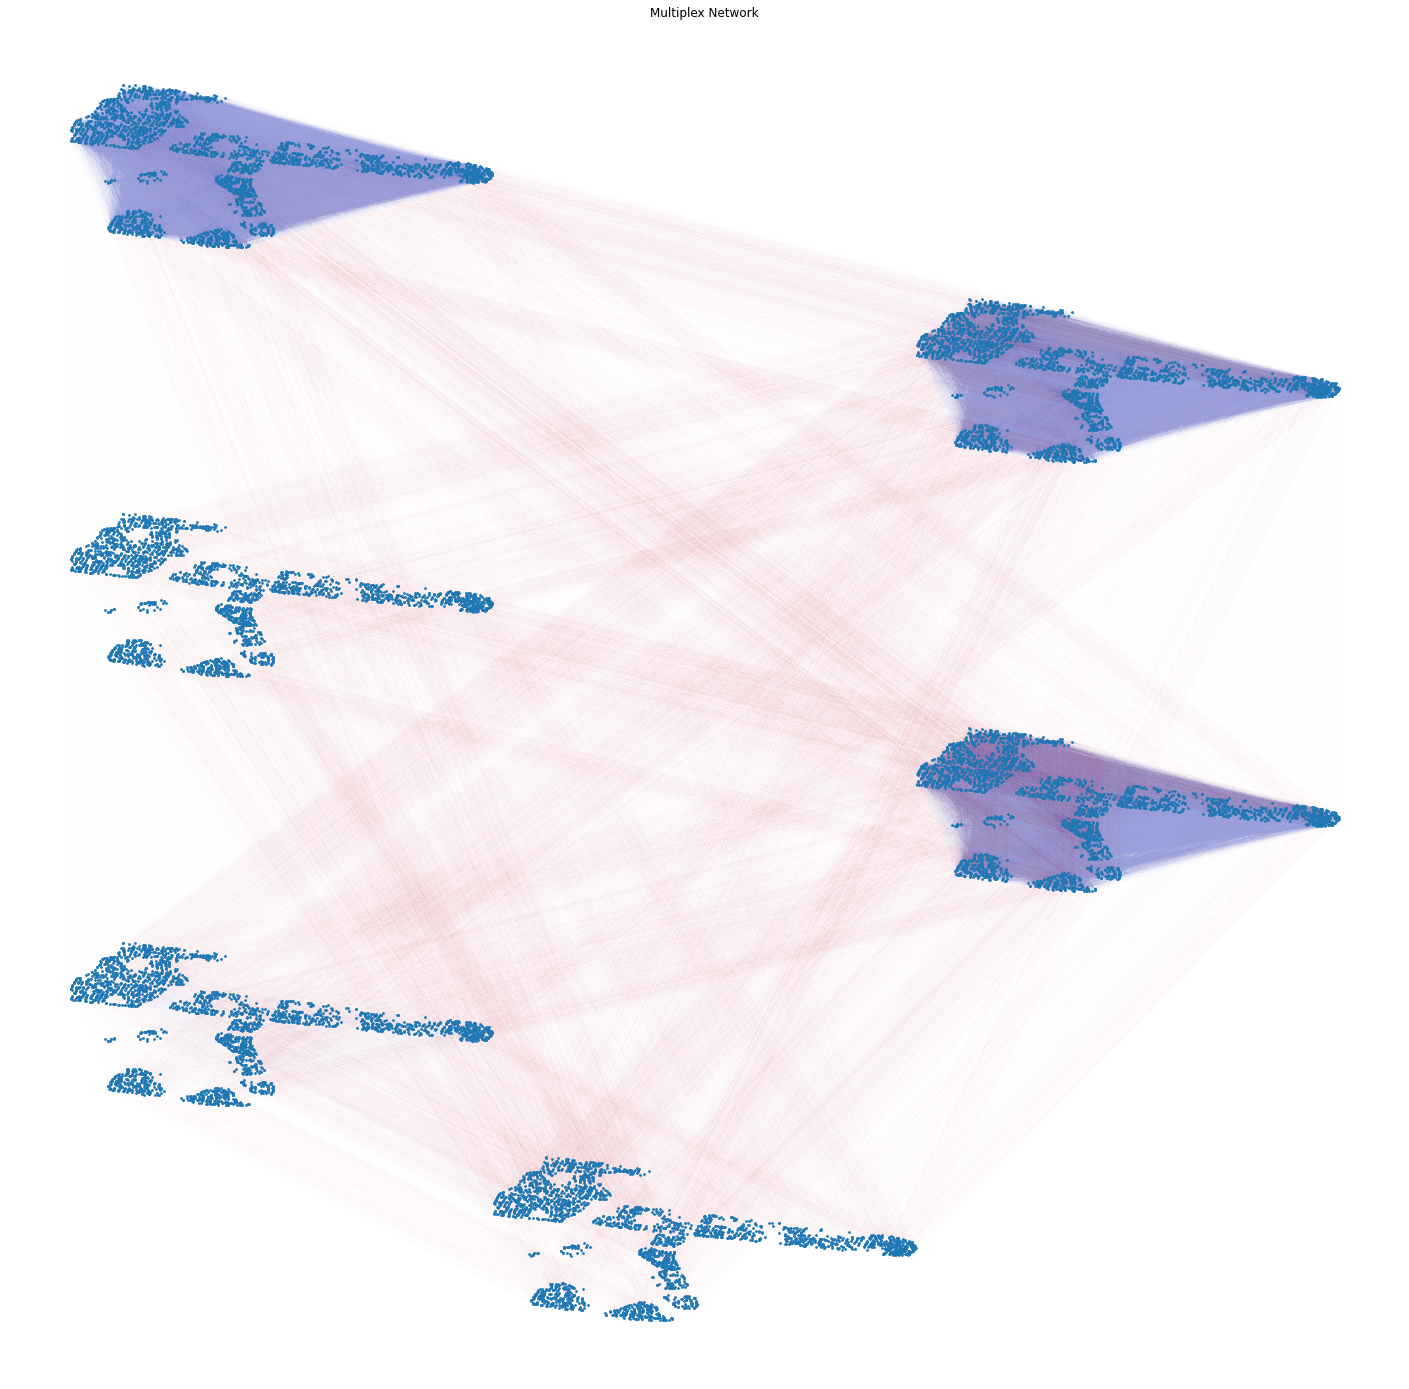

In [ ]:
### Scegliere un umano per classe focale --- > subnetwork per ogni layer 
fig = plt.figure(figsize=(25,25))

plt.axis('off')
plt.title('Multiplex Network')

mx.draw_networkx(multi_net,pos=pos,node_size=3,with_labels=False,
				 edge_color=[multi_net[a][b]['weight'] for a,b in multi_net.edges()],
				 edge_cmap=plt.cm.coolwarm_r, width = 0.005)

# Save just the portion _inside_ the second axis's boundaries
# extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(path + '/Multiplex_Toronto.png', dpi = 600)

plt.show()

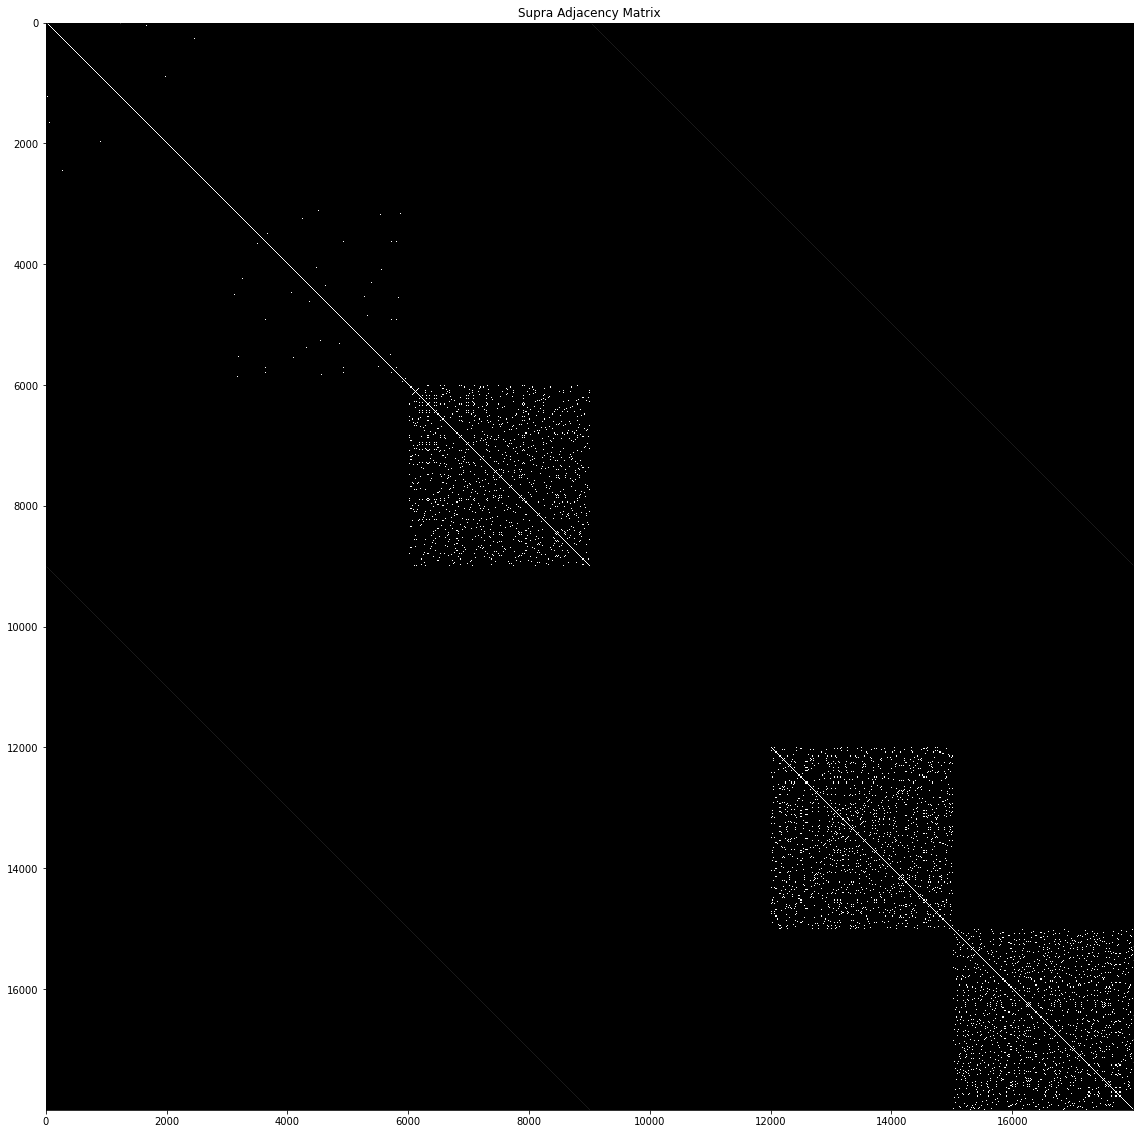

In [ ]:
fig = plt.figure(figsize=(20,20))
plt.imshow(mx.adjacency_matrix(multi_net,weight='weight').todense(),
		  origin='upper',interpolation='nearest',cmap=plt.cm.gray)
plt.title('Supra Adjacency Matrix')
plt.savefig(path + "Toronto_Supra_Adj.png", dpi = 600)

plt.show()